In [1]:
import glob
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import seaborn as sns
import numpy as np
from venny4py.venny4py import *

from collections import Counter

plt.rcParams['font.family'] = 'Arial'

# Testing models

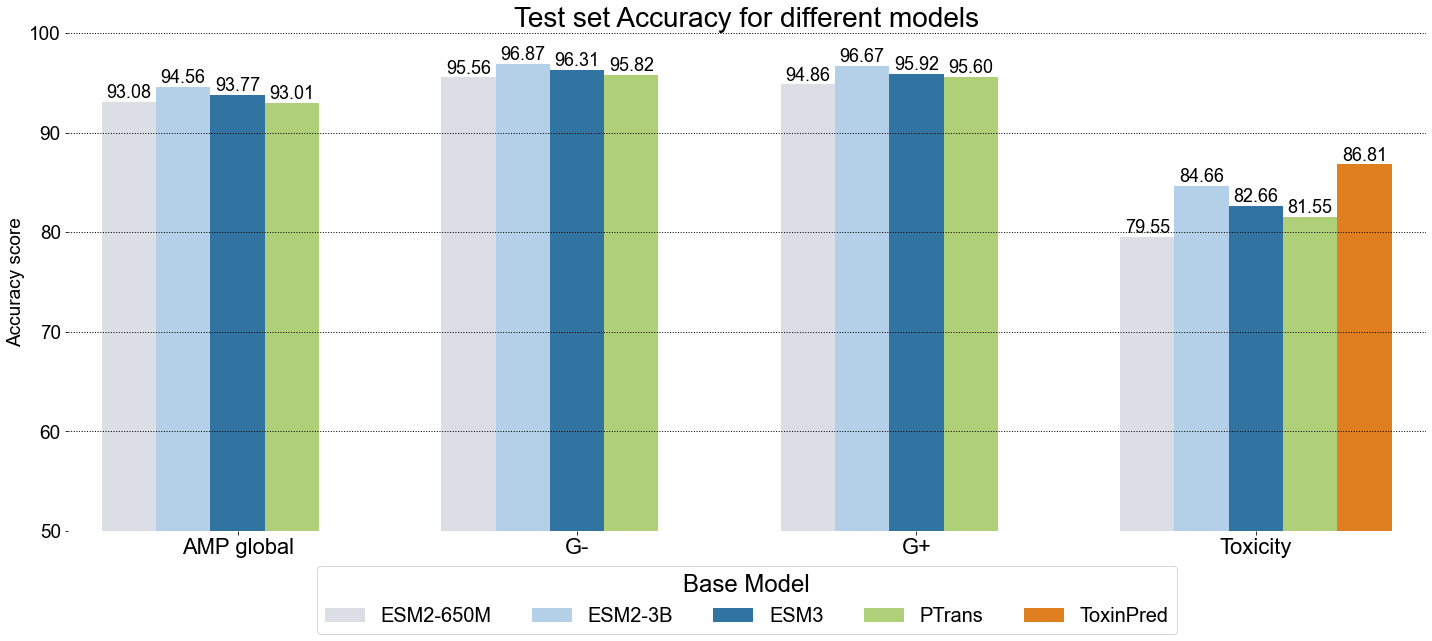

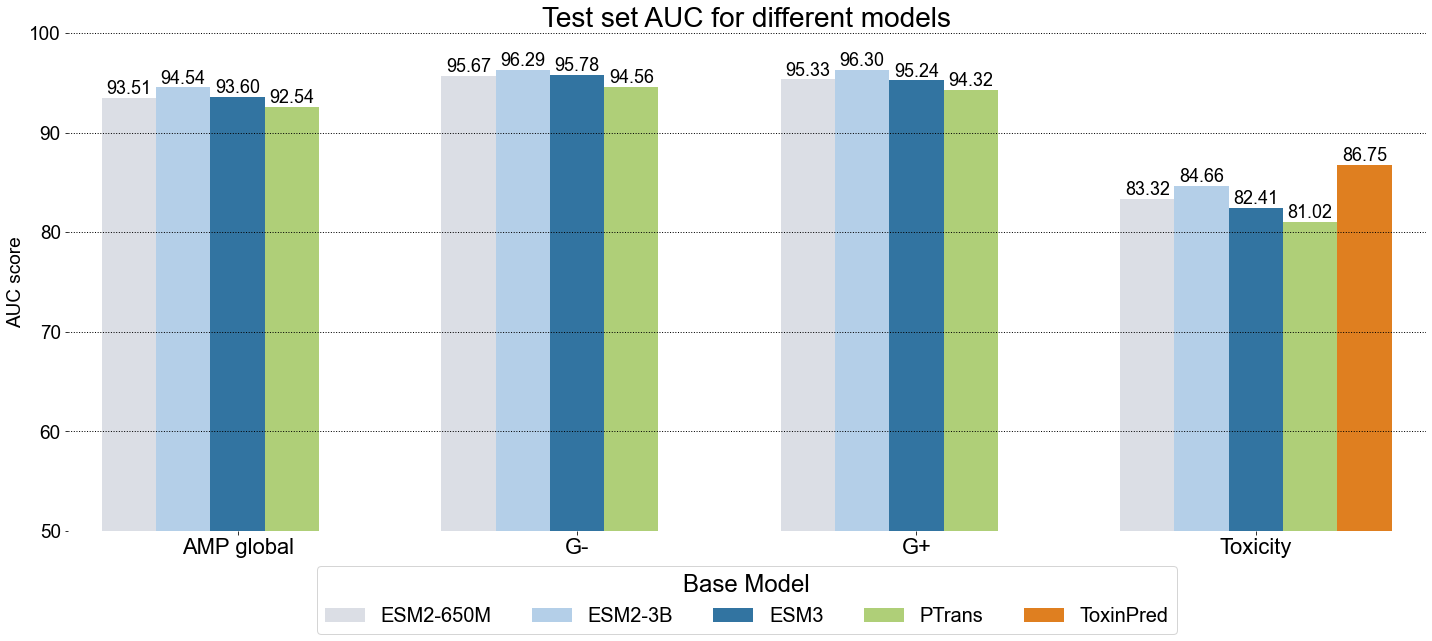

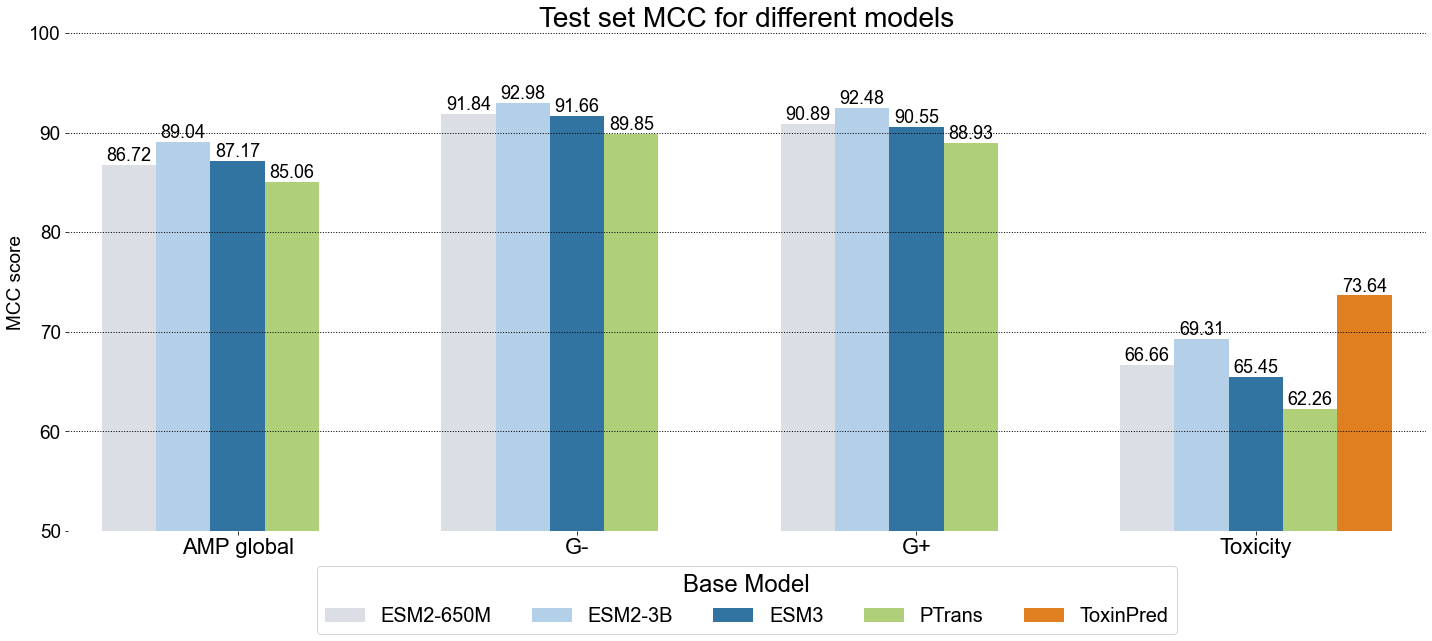

In [94]:
palette = ["#D9DEE7", "#ABD0F1", "#1F78B4", "#B3DE69", "#FF7F00"]
def plot_model_performance(results_path='../data/predictions/lab_validation_2nd_round/AMP_test.csv', metric='Accuracy'):
    amp_df = pd.read_csv(results_path)
    amp_df.loc[:, 'Base model'] = amp_df['Base model'].str.replace('ESM-2 (650m)', 'ESM2-650M')

    dataset_order = ['AMP global', 'G-', 'G+', 'Toxicity']
    show_models = ['ESM2-650M', 'ESM2-3B', 'ESM3', 'PTrans', 'ToxinPred']

    amp_subset_df = amp_df[amp_df['Dataset'].isin(dataset_order)]
    amp_subset_df = amp_subset_df[amp_subset_df['Base model'].isin(show_models)]
    # Remove duplicated scores added later
    amp_subset_df = amp_subset_df.drop_duplicates(subset=['Dataset', 'Base model', 'Metric'], keep='first')

    amp_subset_df = amp_subset_df.sort_values(
        ['Dataset', 'Base model'],
        key=lambda col: col.map(
            {**{v: i for i, v in enumerate(dataset_order)}, **{v: i for i, v in enumerate(show_models)}}
        )
    )
#     palette = ["#FFD166", "#FF7F0E", "#279E68", "#D62728", "#AA40FC", "#17BECF", "#B5BD61", "#FF9896", "#9EDAE5", "#06D6A0", "#0095B7", "#826400", "#FDE4CF"]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 9))
    barplot = sns.barplot(data=amp_subset_df[amp_subset_df['Metric'] == metric], x='Dataset', y='Score', hue='Base model', palette=palette)
    plt.ylim([50, 100])
    plt.grid(axis='y', zorder=0, linewidth=1, linestyle=':', color='k')
    plt.legend(prop={'size': 11})
    plt.title(f'Test set {metric} for different models', size=28)
    plt.box(False)
    plt.xlabel(None)
    plt.xticks(size=22)
    plt.yticks(size=19)
    plt.ylabel(f'{metric} score', size=19)

    # Annotate each bar with the value inside
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), textcoords = 'offset points',
                         fontsize=18)  # Set font size and bold
    # Set legend to be horizontal below the plot
    plt.legend(
        title='Base Model', 
        bbox_to_anchor=(0.5, -0.05),  # Adjust position to make the legend wider
        loc='upper center', 
        ncol=len(show_models),  # Adjust the number of columns based on the number of models
        prop={'size': 20},  # Font size for legend items
        title_fontsize=24  # Larger font size for the legend title
    )

    plt.tight_layout()

    plt.savefig(f'../data/predictions/lab_validation_2nd_round/testing_models_round2_{metric}.png', dpi=300, bbox_inches='tight')
for metric in ['Accuracy', 'AUC', 'MCC']:
    plot_model_performance(metric=metric)

In [95]:
# Check sizes of datasets
for ds, ds_path in zip(['amp', 'G+', 'G-', 'tox'], 
                       ['../data/AMP_new/AMP_2024_08_09.tsv', '../data/AMP_new/AMP_2024_09_13_anti_Gram+.tsv',
                        '../data/AMP_new/AMP_2024_09_13_anti_Gram-.tsv', '../data/tox/tox_merged_all.tsv']):

    df = pd.read_csv(ds_path, sep='\t', header=None)
    cnt = Counter(df[3])
    print(f'{ds}, size={len(df)}, 0: {cnt[0]}', f'1: {cnt[1]}')

amp, size=55209, 0: 30205 1: 25004
G+, size=45069, 0: 30205 1: 14864
G-, size=45493, 0: 30205 1: 15288
tox, size=12961, 0: 6643 1: 6318


In [96]:
# Check sizes of test datasets
for ds, ds_path in zip(['amp', 'G+', 'G-', 'tox'], 
                       ['../data/AMP_new/AMP_2024_08_09_test.tsv', '../data/AMP_new/AMP_2024_09_13_anti_Gram+_test.tsv',
                        '../data/AMP_new/AMP_2024_09_13_anti_Gram-_test.tsv', '../data/tox/tox_test.tsv']):

    df = pd.read_csv(ds_path, sep='\t', header=None)
    cnt = Counter(df[3])
    print(f'{ds}, size={len(df)}, 0: {cnt[0]}', f'1: {cnt[1]}')

amp, size=5521, 0: 3021 1: 2500
G+, size=4507, 0: 3021 1: 1486
G-, size=4550, 0: 3021 1: 1529
tox, size=1297, 0: 665 1: 632


# Comparing with existing solutions

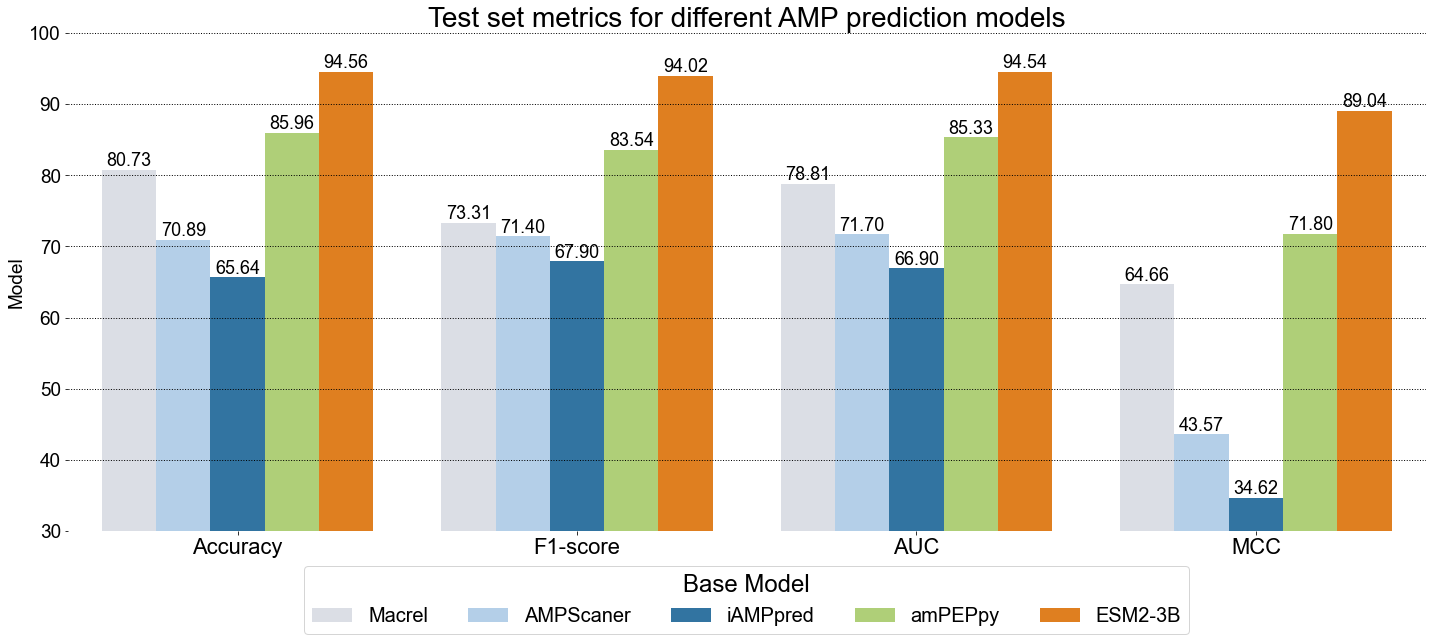

In [97]:
results_path='../data/predictions/lab_validation_2nd_round/AMP_test.csv'
amp_df = pd.read_csv(results_path)

dataset_order = ['AMP global']
show_models = ['Macrel', 'AMPScaner', 'iAMPpred', 'amPEPpy', 'ESM2-3B']
metric_list = ['Accuracy', 'F1-score', 'AUC', 'MCC']

amp_subset_df = amp_df[amp_df['Dataset'].isin(dataset_order)]
amp_subset_df = amp_subset_df[amp_subset_df['Base model'].isin(show_models)]
amp_subset_df = amp_subset_df[amp_subset_df['Metric'].isin(metric_list)]

amp_subset_df = amp_subset_df.sort_values(
    ['Dataset', 'Base model'],
    key=lambda col: col.map(
        {**{v: i for i, v in enumerate(dataset_order)}, **{v: i for i, v in enumerate(show_models)}}
    )
)
# palette = ["#FFD166", "#FF7F0E", "#279E68", "#D62728", "#AA40FC", "#17BECF", "#B5BD61", "#FF9896", "#9EDAE5", "#06D6A0", "#0095B7", "#826400", "#FDE4CF"]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 9))
barplot = sns.barplot(data=amp_subset_df, x='Metric', y='Score', hue='Base model', palette=palette)
plt.ylim([30, 100])
plt.grid(axis='y', zorder=0, linewidth=1, linestyle=':', color='k')
plt.legend(prop={'size': 11})
plt.title(f'Test set metrics for different AMP prediction models', size=28)
plt.box(False)
plt.xlabel(None)
plt.xticks(size=22)
plt.yticks(size=19)
plt.ylabel(f'Score', size=19)
plt.ylabel(f'Model', size=19)
# Annotate each bar with the value inside
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points',
                     fontsize=18)  # Set font size and bold
# Set legend to be horizontal below the plot
plt.legend(
    title='Base Model', 
    bbox_to_anchor=(0.5, -0.05),  # Adjust position to make the legend wider
    loc='upper center', 
    ncol=len(show_models),  # Adjust the number of columns based on the number of models
    prop={'size': 20},  # Font size for legend items
    title_fontsize=24  # Larger font size for the legend title
)

plt.tight_layout()

plt.savefig(f'../data/predictions/lab_validation_2nd_round/testing_existing_models.png', dpi=300, bbox_inches='tight')

# Lab validation AMP Tox G+ G-

In [98]:
# Merge predictions
# Get data file names
path = '../data/predictions/lab_validation_2nd_round/ripp/'
out_path = path.replace('ripp/', '')
filenames = glob.glob(path + "*.tsv")
top_percs = {'amp': 0.5, 'G+': 0.5, 'G-':0.5, 'tox': 0.50}
intersect_4 = False  # If true uses all 4 models, if false use ESM3, ESM2-3B and PTRANS

dfs_raw = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
orig_df = pd.read_csv('../data/ripp_core/ripp_12720_metagenomics_3989_microbial.tsv', sep='\t', header=None)#.tail(3989)
orig_df.loc[:, 'Type'] = ['Metagenomics' if x < 12720 else 'Microbial' for x in orig_df.index]
print(f'Total number of ripp peptides: {len(orig_df)}')

# Read ToxinPred3 prediction scores
toxin_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/ripp/ripp_12720_metagenomics_3989_microbial_toxinpred.csv')#.tail(3989)
orig_df.loc[:, 'ToxinPred3'] = toxin_df['Prediction'].apply(lambda x: True if x == 'Toxin' else False)
non_toxin_pred = set(orig_df[~orig_df['ToxinPred3']][0])


for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')#.tail(3989)
    size_top_perc = int(len(df) * top_percs[ds])
    dfs_raw[ds][model] = df.copy()

    df = df.sort_values(by='probability', ascending=False)
    # Normalize prediction score:
    df['probability_norm'] = (df['probability'] - df['probability'].min()) / (df['probability'].max() - df['probability'].min())
    df['probability_norm'] = df['probability_norm'].apply(lambda x: np.round(x, 4))
    if np.max(df['probability_norm'] ) > 1:
        display(df)
        break
    
    dfs[ds][model] = df.copy()
    sets[ds][model] = set(df['protein_id'].values)
    
    
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[ds][model] = df
    sets_top_perc[ds][model] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[ds][model]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for amp_ds in ['amp', 'G+', 'G-']:
    for_lab_all_df = orig_df.copy()
    for_lab_all_df = for_lab_all_df.loc[:, for_lab_all_df.columns != 3]  # Remove unnecessary column with random prediction
    for_lab_all_df.columns = ['protein id', 'length', 'sequence', 'Type', 'ToxinPred3']  # ToxinPred 3 column
    # for_lab_all_df.drop_duplicates(subset='sequence', inplace=True)
    print(len(for_lab_all_df))
    score_columns = []
    for lab_ds in [amp_ds, 'tox']:
        for model in ['ESM2-3B', 'ESM3', 'PTRANS']:
            results_df = dfs[lab_ds][model][['protein_id', 'probability_norm', 'prediction']].drop_duplicates(subset='protein_id')
            for_lab_all_df = pd.merge(left=for_lab_all_df, right=results_df, 
                                      left_on='protein id', right_on='protein_id', how='left')

            for_lab_all_df.drop(columns='protein_id', inplace=True)
            for_lab_all_df.rename(columns={'probability_norm': lab_ds + '_' + model + '_norm_score'}, inplace=True)
            for_lab_all_df.rename(columns={'prediction': lab_ds + '_' + model + '_prediction'}, inplace=True)
            score_columns.append(lab_ds + '_' + model + '_norm_score')
    # for_lab_all_df.loc[:, 'avg_score'] = for_lab_all_df[score_columns].mean(axis=1).apply(lambda x: np.round(x, 4))

    # for_lab_all_df.loc[:, f'is_in_top_{int(top_percs[amp_ds]*100)}'] = for_lab_all_df['protein id'].isin(for_lab_top_perc)
    # for_lab_all_df.sort_values(by='prediction', inplace=True, ascending=False)
    for_lab_all_df.to_csv(f'{out_path}lab_validation_all_{amp_ds}.csv', index=False)
    print('-' * 90)

    

Total number of ripp peptides: 16712
ESM2-3B tox: {1: 3051, 0: 13661}
PTRANS tox: {1: 2810, 0: 13902}
ESM2-3B G-: {0: 11219, 1: 5493}
ESM2-3B amp: {1: 9295, 0: 7417}
ESM3 G+: {1: 6498, 0: 10214}
ESM3 amp: {1: 9449, 0: 7263}
ESM3 tox: {1: 1697, 0: 15015}
PTRANS amp: {1: 9313, 0: 7399}
PTRANS G+: {0: 10547, 1: 6165}
PTRANS G-: {0: 11053, 1: 5659}
ESM2-3B G+: {0: 10225, 1: 6487}
ESM3 G-: {1: 5642, 0: 11070}
16712
------------------------------------------------------------------------------------------
16712
------------------------------------------------------------------------------------------
16712
------------------------------------------------------------------------------------------


Total number of ripp peptides: 16712
ESM2-3B tox: {1: 3051, 0: 13661}
PTRANS tox: {1: 2810, 0: 13902}
ESM2-3B G-: {0: 11219, 1: 5493}
ESM2-3B amp: {1: 9295, 0: 7417}
ESM3 G+: {1: 6498, 0: 10214}
ESM3 amp: {1: 9449, 0: 7263}
ESM3 tox: {1: 1697, 0: 15015}
PTRANS amp: {1: 9313, 0: 7399}
PTRANS G+: {0: 10547, 1: 6165}
PTRANS G-: {0: 11053, 1: 5659}
ESM2-3B G+: {0: 10225, 1: 6487}
ESM3 G-: {1: 5642, 0: 11070}
amp active and non-toxic predicted by models: 2745
amp active and non-toxic predicted by models within top 50.0%: 484


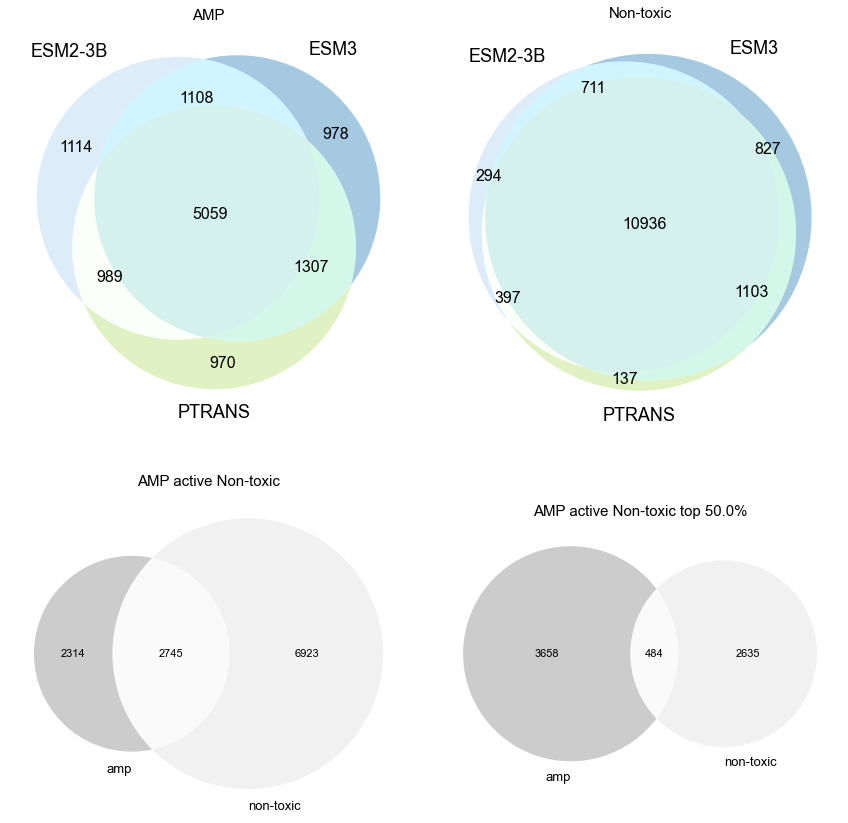

------------------------------------------------------------------------------------------
G+ active and non-toxic predicted by models: 1423
G+ active and non-toxic predicted by models within top 50.0%: 292


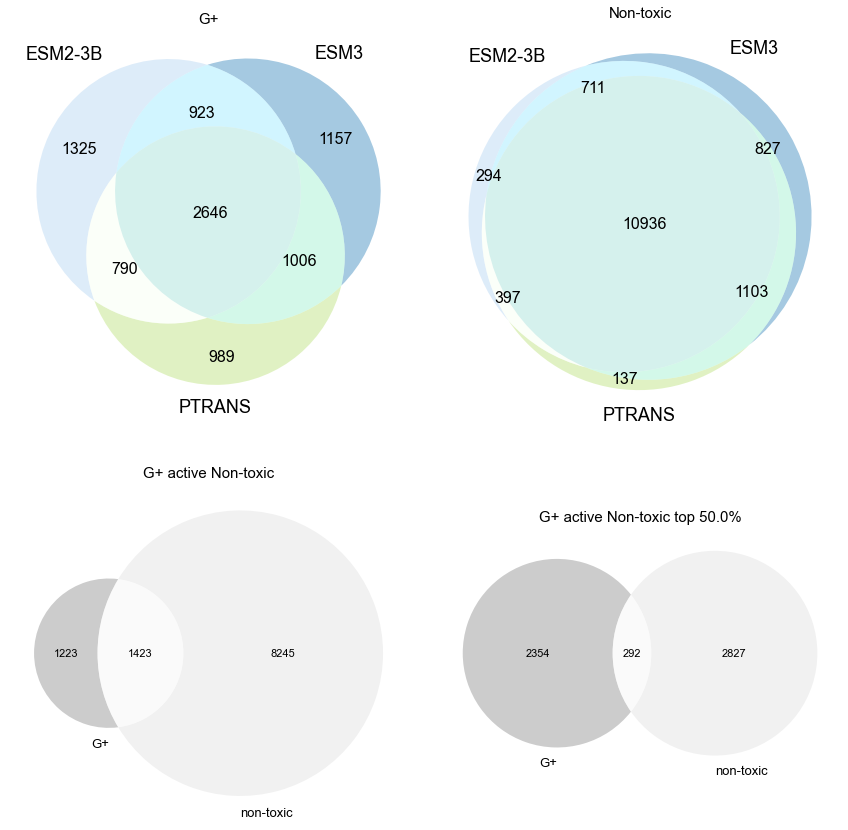

------------------------------------------------------------------------------------------
G- active and non-toxic predicted by models: 1117
G- active and non-toxic predicted by models within top 50.0%: 216


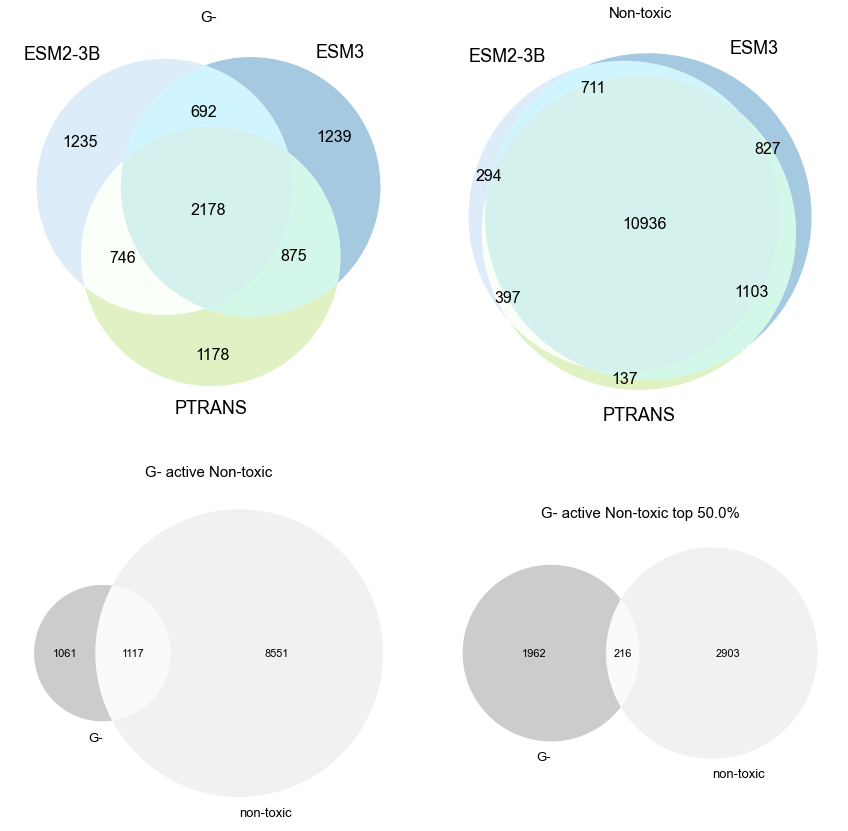

------------------------------------------------------------------------------------------


In [99]:
# Get data file names
path = '../data/predictions/lab_validation_2nd_round/ripp/'
out_path = path.replace('ripp/', '')
filenames = glob.glob(path + "*.tsv")
top_percs = {'amp': 0.5, 'G+': 0.5, 'G-':0.5, 'tox': 0.50}
intersect_4 = False  # If true uses all 4 models, if false use ESM3, ESM2-3B and PTRANS

dfs_raw = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
orig_df = pd.read_csv('../data/ripp_core/ripp_12720_metagenomics_3989_microbial.tsv', sep='\t', header=None)#.tail(3989)
orig_df.loc[:, 'Type'] = ['Metagenomics' if x < 12720 else 'Microbial' for x in orig_df.index]
print(f'Total number of ripp peptides: {len(orig_df)}')

# Read ToxinPred3 prediction scores
toxin_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/ripp/ripp_12720_metagenomics_3989_microbial_toxinpred.csv')#.tail(3989)
orig_df.loc[:, 'ToxinPred3'] = toxin_df['Prediction'].apply(lambda x: True if x == 'Toxin' else False)
non_toxin_pred = set(orig_df[~orig_df['ToxinPred3']][0])


for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')#.tail(3989)
    size_top_perc = int(len(df) * top_percs[ds])

    # Normalize prediction score:
    df['probability_norm'] = (df['probability'] - df['probability'].min()) / (df['probability'].max() - df['probability'].min())
    df['probability_norm'] = df['probability_norm'].apply(lambda x: np.round(x, 4))
    if np.max(df['probability_norm'] ) > 1:
        display(df)
        break
    dfs_raw[ds][model] = df.copy()
    if ds == 'tox':
        df = df[df['prediction'] == 0]  # Keep only non-toxic
    else:
        df = df[df['prediction'] == 1]  # Keep only AMP active
    df = df.sort_values(by='probability', ascending=False)
    
    dfs[ds][model] = df.copy()
    sets[ds][model] = set(df['protein_id'].values)
    
    
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[ds][model] = df
    sets_top_perc[ds][model] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[ds][model]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for amp_ds in ['amp', 'G+', 'G-']:
    if intersect_4:
        amp_active = set.intersection(*list(sets[amp_ds].values()))
        non_toxic = set.intersection(*list(sets['tox'].values())).intersection(non_toxin_pred)
        amp_active_top = set.intersection(*list(sets_top_perc[amp_ds].values()))
        non_toxic_top = set.intersection(*list(sets_top_perc['tox'].values())).intersection(non_toxin_pred)
    else:
        amp_active = set.intersection(*[sets[amp_ds]['ESM2-3B'], sets[amp_ds]['ESM3'], sets[amp_ds]['PTRANS']])
        non_toxic = set.intersection(*[sets['tox']['ESM2-3B'], sets['tox']['ESM3'], sets['tox']['PTRANS']]).intersection(non_toxin_pred)
        amp_active_top = set.intersection(*[sets_top_perc[amp_ds]['ESM2-3B'], sets_top_perc[amp_ds]['ESM3'], sets_top_perc[amp_ds]['PTRANS']])
        non_toxic_top = set.intersection(*[sets_top_perc['tox']['ESM2-3B'], sets_top_perc['tox']['ESM3'], sets_top_perc['tox']['PTRANS']]).intersection(non_toxin_pred)

    
    for_lab = amp_active.intersection(non_toxic)
    for_lab_top_perc = amp_active_top.intersection(non_toxic_top)
    
    print(f'{amp_ds} active and non-toxic predicted by models: {len(for_lab)}')
    print(f'{amp_ds} active and non-toxic predicted by models within top {top_percs[amp_ds] * 100}%: {len(for_lab_top_perc)}')
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    fig.tight_layout(pad=0.1)  # Adjust spacing between subplots
    fig.gca().set_facecolor(None)
    
    for ind_st, st in enumerate([sets]):     # sets_top_perc
        for ind, ds in enumerate([amp_ds, 'tox']):
#             venn = venn2([st[ds]['ESM2'], st[ds]['ESM3']], set_labels=tuple('ESM2', 'ESM3'), ax=axs[ind_st][ind])
            if intersect_4:
                venn = venny4py(sets=st[ds], asax=axs[ind_st][ind])
            else:
                venn = venn3([st[ds]['ESM2-3B'], st[ds]['ESM3'], st[ds]['PTRANS']], set_labels=('ESM2-3B', 'ESM3', 'PTRANS'), 
                             set_colors=palette[1:], ax=axs[ind_st][ind])
                axs[ind_st][ind].set_facecolor('none')
                for text in venn.set_labels:
                    text.set_fontsize(18)
                for text in venn.subset_labels:
                    if text:
                        text.set_fontsize(16)
            title_ds = ds.replace('amp', 'AMP').replace('tox', 'Non-toxic')
            axs[ind_st][ind].set_title(f"{title_ds}" + ((f' top {top_percs[ds]*100}%') if ind_st > 0 else ''), size=15)

    for ind, (act, tox) in enumerate(zip([amp_active, amp_active_top], [non_toxic, non_toxic_top])): 
        venn = venn2([act, tox], set_labels=tuple([amp_ds, 'non-toxic']), set_colors=['#808080', '#DCDCDC'], ax=axs[1][ind])
        for text in venn.set_labels:
            text.set_fontsize(13)
        for text in venn.subset_labels:
            if text:
                text.set_fontsize(11)
        title_amp_ds = amp_ds.replace('amp', 'AMP')
        axs[1][ind].set_title(f"{title_amp_ds} active Non-toxic" + ((f' top {top_percs[amp_ds]*100}%') if ind > 0 else ''), size=15)

    plt.savefig(f'{out_path}{amp_ds}_tox_ripp_venn.png', dpi=200, bbox_inches='tight')
    plt.show()
  
    for_lab_all_df = orig_df[ orig_df[0].isin(for_lab)]
    
    for_lab_all_df = for_lab_all_df.loc[:, for_lab_all_df.columns != 3]
    for_lab_all_df.columns = ['protein id', 'length', 'sequence', 'Type', 'ToxinPred3']  # ToxinPred 3 column
    for_lab_all_df.drop_duplicates(subset='sequence', inplace=True)
    score_columns = []
    for lab_ds in [amp_ds, 'tox']:
        for model in ['ESM2-3B', 'ESM3', 'PTRANS']:
            results_df = dfs[lab_ds][model][['protein_id', 'probability_norm']].drop_duplicates(subset='protein_id')
            for_lab_all_df = pd.merge(left=for_lab_all_df, right=results_df, 
                                      left_on='protein id', right_on='protein_id', how='left')

            for_lab_all_df.drop(columns='protein_id', inplace=True)
            for_lab_all_df.rename(columns={'probability_norm': lab_ds + '_' + model + '_norm_score'}, inplace=True)
            score_columns.append(lab_ds + '_' + model + '_norm_score')
    for_lab_all_df.loc[:, 'avg_score'] = for_lab_all_df[score_columns].mean(axis=1).apply(lambda x: np.round(x, 4))

    for_lab_all_df.loc[:, f'is_in_top_{int(top_percs[amp_ds]*100)}'] = for_lab_all_df['protein id'].isin(for_lab_top_perc)
    for_lab_all_df.sort_values(by='avg_score', inplace=True, ascending=False)
    for_lab_all_df.to_csv(f'{out_path}lab_validation_{amp_ds}_new.csv', index=False)
    print('-' * 90)


# Agregate and save all the scores

In [100]:
orig_df

,0,1,2,3,Type,ToxinPred3
0,ABD.bin.1_k119_94503.region001-gene12,99,IGQTKVCNLVAGGAVSIVISSGTNACCPCVPGSTKFDPVKCARDQC...,1,Metagenomics,False
1,ABD.bin.10_k119_24795.region001-gene6,42,TFMKKVAYTAPTLITLGYLSKAELIHADGTGGPDGPPGGWTP,1,Metagenomics,False
2,BSO.bin.106_k119_263622.region001-gene7,40,KTVLKIGETLTGRLLLLDGLTMEWQTMKLKKNQNCPTCGC,0,Metagenomics,False
3,BSO.bin.11_k119_901672.region001-gene20,25,TMKWETPAYTDLRFGFEVTMYIYNR,1,Metagenomics,False
4,BSO.bin.130_k119_437925.region001-gene6,55,GAKDHHDHLICTKCGSITEFVDEEIENRQHNIANELGFTMQDHSMQ...,0,Metagenomics,False
...,...,...,...,...,...,...
16707,GCF_904830995.1_NZ_CAJGVD010000001.1.region002...,19,GTDMGTLPENDFGVWRPLA,0,Microbial,False
16708,GCF_948330325.1_NZ_CAOJBU010000015.1.region001...,6,SCFWFA,0,Microbial,False
16709,G2-11-1_00.bin.33_k141_1761215.region001_gene6,40,FMGRALPTPQSALPRRAWNRVVRDWLAPADETHTGQRSFR,0,Microbial,False
16710,GCF_001816105.1_NZ_LYTG01000052.1.region001_gene6,69,HGSSRYRFTAAWNAPLPFLTESIASVVCLAPLNFRRGVTRLVSYYA...,1,Microbial,False


In [102]:
new_orig_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/16618corepeptides_toVlad_0106.csv')
print(len(new_orig_df))

for ds, model_dict in dfs_raw.items():
    for model, raw_df in model_dict.items():
        df = raw_df.copy()
        df.rename(columns={'prediction': f'prediction_{ds}_{model}', 'probability_norm': f'probability_{ds}_{model}'}, inplace=True)
        df = pd.merge(left=df, right=orig_df[[0, 2]], left_on='protein_id', right_on=0, how='left')
        df.drop_duplicates(subset=2, keep='first', inplace=True)
        df = df.drop(columns=[0, 'protein_id', 'probability'])
        new_orig_df = pd.merge(left=new_orig_df, right=df, left_on='corepeptide', right_on=2, how='left')
        new_orig_df = new_orig_df.drop(columns=[2])

orig_dd_df = orig_df.drop_duplicates(subset=2, keep='first')
new_orig_df = pd.merge(left=new_orig_df, right=orig_dd_df[[2, 'ToxinPred3']], left_on='corepeptide', right_on=2, how='left')
print(len(new_orig_df))
new_orig_df = new_orig_df.drop(columns=[2])

display(new_orig_df)
print(len(new_orig_df))
new_orig_df.to_csv('../data/predictions/lab_validation_2nd_round/16618_corepeptides_scored.csv', index=False)

16618
16618


,genome,genome_type,BGC,pep_id,corepeptide,ripp_type,corepep.length,Note,prediction_amp_ESM2-3B,probability_amp_ESM2-3B,...,probability_G-_PTRANS,prediction_G-_ESM3,probability_G-_ESM3,prediction_tox_ESM2-3B,probability_tox_ESM2-3B,prediction_tox_PTRANS,probability_tox_PTRANS,prediction_tox_ESM3,probability_tox_ESM3,ToxinPred3
0,GCF_000009785.1,SAGs,GCF_000009785.1_NC_006510.1.region001,GCF_000009785.1_NC_006510.1.region001_gene1,ITSKSLCTPGCITGILMCLTQNSCVSCNSCIRC,CLASS_I_LANTIPEPTIDE,33,NaN,1,0.7878,...,0.0042,1,0.7819,0,0.9684,0,0.3897,0,0.9990,False
1,GCF_000239155.1,SAGs,GCF_000239155.1_NZ_AGVX02000116.1.region001,GCF_000239155.1_NZ_AGVX02000116.1.region001_gene1,SCTTCECCCSCSS,THIOPEPTIDE,13,NaN,1,0.9730,...,0.8774,0,0.9978,1,0.9938,1,0.9753,1,0.9992,False
2,GCF_000242715.1,SAGs,GCF_000242715.1_NZ_AHBF01000142.1.region001,GCF_000242715.1_NZ_AHBF01000142.1.region001_gene1,LADSPSGRQPMHAFGGGRLADGPSRGQPVHGLGSRRLADSPA,LASSO_PEPTIDE,42,NaN,1,1.0000,...,0.6041,1,0.9992,0,0.9994,0,0.8344,0,0.9824,False
3,GCF_000250735.1,SAGs,GCF_000250735.1_NZ_AHZV01000224.1.region001,GCF_000250735.1_NZ_AHZV01000224.1.region001_gene1,AMGGALGRRAPSDKLNIAGVG,BACTERIAL_HEAD_TO_TAIL_CYCLIZED,21,NaN,1,0.2657,...,0.0984,0,0.8661,0,0.9502,0,0.8356,0,1.0000,False
4,GCF_000296615.1,SAGs,GCF_000296615.1_NZ_JH815330.1.region002,GCF_000296615.1_NZ_JH815330.1.region002_gene1,WPLEAAHELGEEADWPVQYRRGRFD,LASSO_PEPTIDE,25,NaN,1,0.7850,...,0.0906,0,0.3480,0,0.9636,0,0.8503,0,1.0000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16613,SSF.bin.27,MAGs,SSF.bin.27_k119_561297.region001,SSF.bin.27_k119_561297.region001_gene11,IDGISIDELVEKYGSPLFVISEKKLREKIQEYI,LASSO_PEPTIDE,33,NaN,0,0.8628,...,0.4571,0,0.9984,1,0.1579,0,0.8494,0,0.9970,False
16614,SSF.bin.31,MAGs,SSF.bin.31_k119_1326831.region001,SSF.bin.31_k119_1326831.region001_gene5,KSGKFGKVFPERFFQYGDCRD,LASSO_PEPTIDE,21,NaN,1,0.9708,...,0.5081,1,0.9978,1,0.4307,0,0.4133,0,0.9590,True
16615,G2-11-1_00.bin.33,MAGs,G2-11-1_00.bin.33_k141_1761215.region001,G2-11-1_00.bin.33_k141_1761215.region001_gene6,FMGRALPTPQSALPRRAWNRVVRDWLAPADETHTGQRSFR,LASSO_PEPTIDE,40,NaN,0,0.4485,...,0.7485,0,0.0552,1,0.3273,0,0.5190,0,0.9862,False
16616,GCF_001816105.1,SAGs,GCF_001816105.1_NZ_LYTG01000052.1.region001,GCF_001816105.1_NZ_LYTG01000052.1.region001_gene6,HGSSRYRFTAAWNAPLPFLTESIASVVCLAPLNFRRGVTRLVSYYA...,LASSO_PEPTIDE,69,NaN,0,0.9998,...,0.9884,0,1.0000,0,0.9299,0,0.5216,1,0.8078,False


16618


In [2]:
scored_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/16618_corepeptides_scored.csv')
scored_df

/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_30582/1471170307.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  scored_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/16618_corepeptides_scored.csv')


,genome,genome_type,BGC,pep_id,corepeptide,ripp_type,corepep.length,Note,prediction_amp_ESM2-3B,probability_amp_ESM2-3B,...,probability_G-_PTRANS,prediction_G-_ESM3,probability_G-_ESM3,prediction_tox_ESM2-3B,probability_tox_ESM2-3B,prediction_tox_PTRANS,probability_tox_PTRANS,prediction_tox_ESM3,probability_tox_ESM3,ToxinPred3
0,GCF_000009785.1,SAGs,GCF_000009785.1_NC_006510.1.region001,GCF_000009785.1_NC_006510.1.region001_gene1,ITSKSLCTPGCITGILMCLTQNSCVSCNSCIRC,CLASS_I_LANTIPEPTIDE,33,NaN,1,0.7878,...,0.0042,1,0.7819,0,0.9684,0,0.3897,0,0.9990,False
1,GCF_000239155.1,SAGs,GCF_000239155.1_NZ_AGVX02000116.1.region001,GCF_000239155.1_NZ_AGVX02000116.1.region001_gene1,SCTTCECCCSCSS,THIOPEPTIDE,13,NaN,1,0.9730,...,0.8774,0,0.9978,1,0.9938,1,0.9753,1,0.9992,False
2,GCF_000242715.1,SAGs,GCF_000242715.1_NZ_AHBF01000142.1.region001,GCF_000242715.1_NZ_AHBF01000142.1.region001_gene1,LADSPSGRQPMHAFGGGRLADGPSRGQPVHGLGSRRLADSPA,LASSO_PEPTIDE,42,NaN,1,1.0000,...,0.6041,1,0.9992,0,0.9994,0,0.8344,0,0.9824,False
3,GCF_000250735.1,SAGs,GCF_000250735.1_NZ_AHZV01000224.1.region001,GCF_000250735.1_NZ_AHZV01000224.1.region001_gene1,AMGGALGRRAPSDKLNIAGVG,BACTERIAL_HEAD_TO_TAIL_CYCLIZED,21,NaN,1,0.2657,...,0.0984,0,0.8661,0,0.9502,0,0.8356,0,1.0000,False
4,GCF_000296615.1,SAGs,GCF_000296615.1_NZ_JH815330.1.region002,GCF_000296615.1_NZ_JH815330.1.region002_gene1,WPLEAAHELGEEADWPVQYRRGRFD,LASSO_PEPTIDE,25,NaN,1,0.7850,...,0.0906,0,0.3480,0,0.9636,0,0.8503,0,1.0000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16613,SSF.bin.27,MAGs,SSF.bin.27_k119_561297.region001,SSF.bin.27_k119_561297.region001_gene11,IDGISIDELVEKYGSPLFVISEKKLREKIQEYI,LASSO_PEPTIDE,33,NaN,0,0.8628,...,0.4571,0,0.9984,1,0.1579,0,0.8494,0,0.9970,False
16614,SSF.bin.31,MAGs,SSF.bin.31_k119_1326831.region001,SSF.bin.31_k119_1326831.region001_gene5,KSGKFGKVFPERFFQYGDCRD,LASSO_PEPTIDE,21,NaN,1,0.9708,...,0.5081,1,0.9978,1,0.4307,0,0.4133,0,0.9590,True
16615,G2-11-1_00.bin.33,MAGs,G2-11-1_00.bin.33_k141_1761215.region001,G2-11-1_00.bin.33_k141_1761215.region001_gene6,FMGRALPTPQSALPRRAWNRVVRDWLAPADETHTGQRSFR,LASSO_PEPTIDE,40,NaN,0,0.4485,...,0.7485,0,0.0552,1,0.3273,0,0.5190,0,0.9862,False
16616,GCF_001816105.1,SAGs,GCF_001816105.1_NZ_LYTG01000052.1.region001,GCF_001816105.1_NZ_LYTG01000052.1.region001_gene6,HGSSRYRFTAAWNAPLPFLTESIASVVCLAPLNFRRGVTRLVSYYA...,LASSO_PEPTIDE,69,NaN,0,0.9998,...,0.9884,0,1.0000,0,0.9299,0,0.5216,1,0.8078,False


In [26]:
scored_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/16618_corepeptides_scored.csv')
scored_df
for amp in ['amp', 'G-', 'G+']:
    for model in ['ESM2-3B', 'ESM3', 'PTRANS']:
        scored_df.loc[:, f'top_50%_{amp}_{model}'] = (scored_df.loc[:, f'prediction_tox_{model}'] == 0) & \
        (scored_df.loc[:, f'prediction_{amp}_{model}'] == 1)
        median_tox = np.median(scored_df[scored_df.loc[:, f'top_50%_{amp}_{model}'] == 1][f'probability_tox_{model}'])
        median_amp = np.median(scored_df[scored_df.loc[:, f'top_50%_{amp}_{model}'] == 1][f'probability_{amp}_{model}'])
        scored_df.loc[:, f'top_50%_{amp}_{model}'] = \
            scored_df.loc[:, [f'top_50%_{amp}_{model}', f'probability_tox_{model}', f'probability_{amp}_{model}']].apply( \
            lambda x: (x.iloc[0] == 1) & (x.iloc[1] >= median_tox) & (x.iloc[2] >= median_amp), axis=1)
    scored_df.loc[:, f'top_50%_{amp}'] = scored_df.loc[:, f'top_50%_{amp}_ESM2-3B'] & scored_df.loc[:, f'top_50%_{amp}_ESM3'] & scored_df.loc[:, f'top_50%_{amp}_PTRANS']
scored_df.to_csv('../data/predictions/lab_validation_2nd_round/16618_corepeptides_scored_top50.csv', index=False)    

/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_30582/1691249825.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  scored_df = pd.read_csv('../data/predictions/lab_validation_2nd_round/16618_corepeptides_scored.csv')


In [43]:
# only_3_df = new_orig_df[['pep_id', 'corepep.length', 'corepeptide']].tail(3)
# only_3_df[3] = [0, 1, 1]
# only_3_df.to_csv('only_3.tsv', sep='\t', index=False, header=False)

# XGB

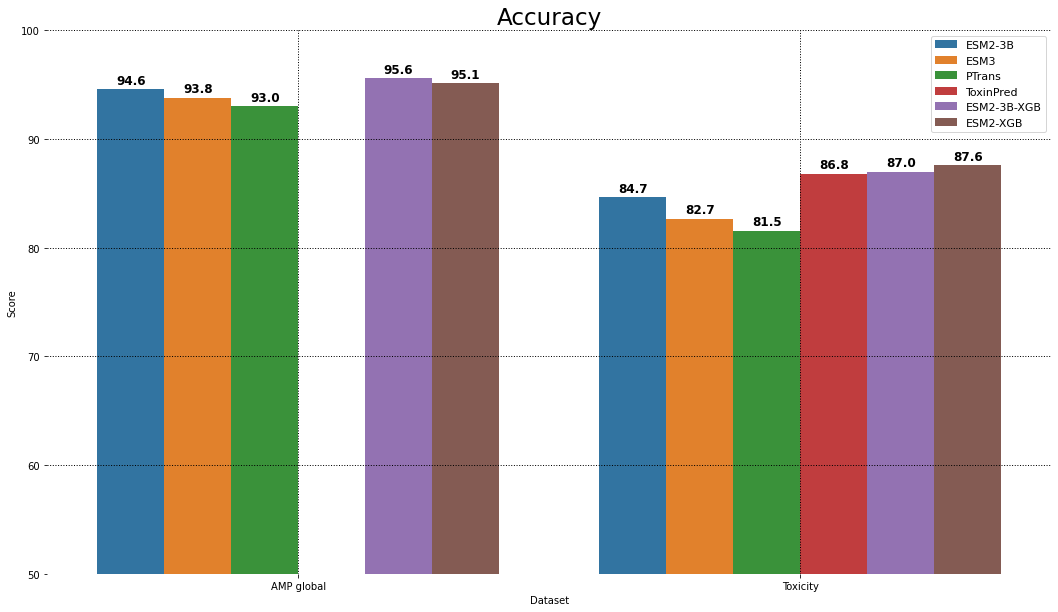

In [44]:
amp_subset_df = amp_df[amp_df['Dataset'].isin(['AMP global', 'Toxicity'])]
amp_subset_df = amp_subset_df[amp_subset_df['Base model'].isin(['ESM2-3B', 'ESM3', 'PTrans', 'ToxinPred', 'ESM2-3B-XGB', 'ESM2-XGB'])]
metric = 'Accuracy'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
barplot = sns.barplot(data=amp_subset_df[amp_subset_df['Metric'] == metric], x='Dataset', y='Score', hue='Base model')
plt.ylim([50, 100])
plt.grid(zorder=0, linewidth=1, linestyle=':', color='k')
plt.legend(prop={'size': 11})
plt.title(metric, size=23)
plt.box(False)

# Annotate each bar with the value inside
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points',
                     fontsize=12, fontweight='bold')  # Set font size and bold
plt.savefig(f'testing_models_xgb.png', dpi=200, bbox_inches='tight')

# Peptide properties

Global AMP: Total 55209 sequences (1: 25004, 0: 30205)
Gram+: Total 45069 sequences (1: 14864, 0: 30205)
Gram-: Total 45493 sequences (1: 15288, 0: 30205)
Toxicity: Total 12961 sequences (1: 6318, 0: 6643)


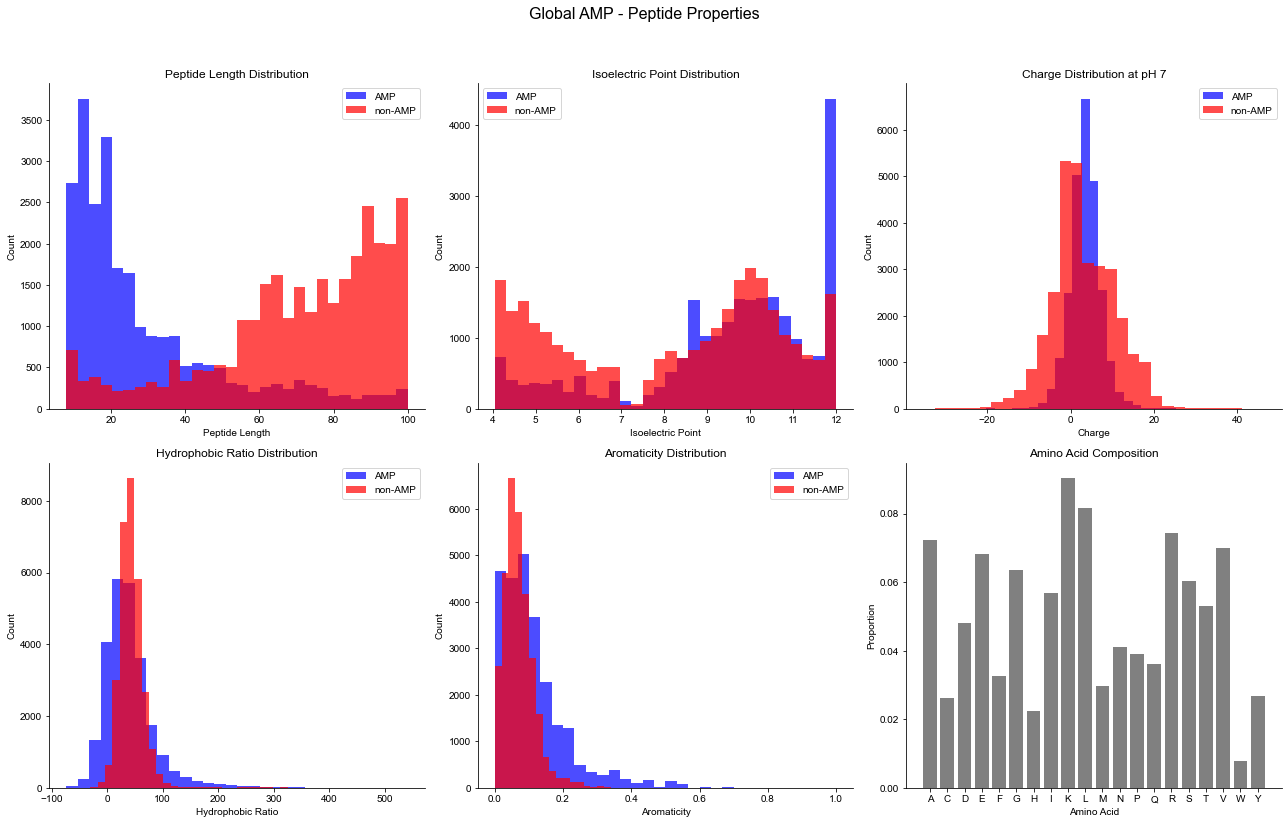

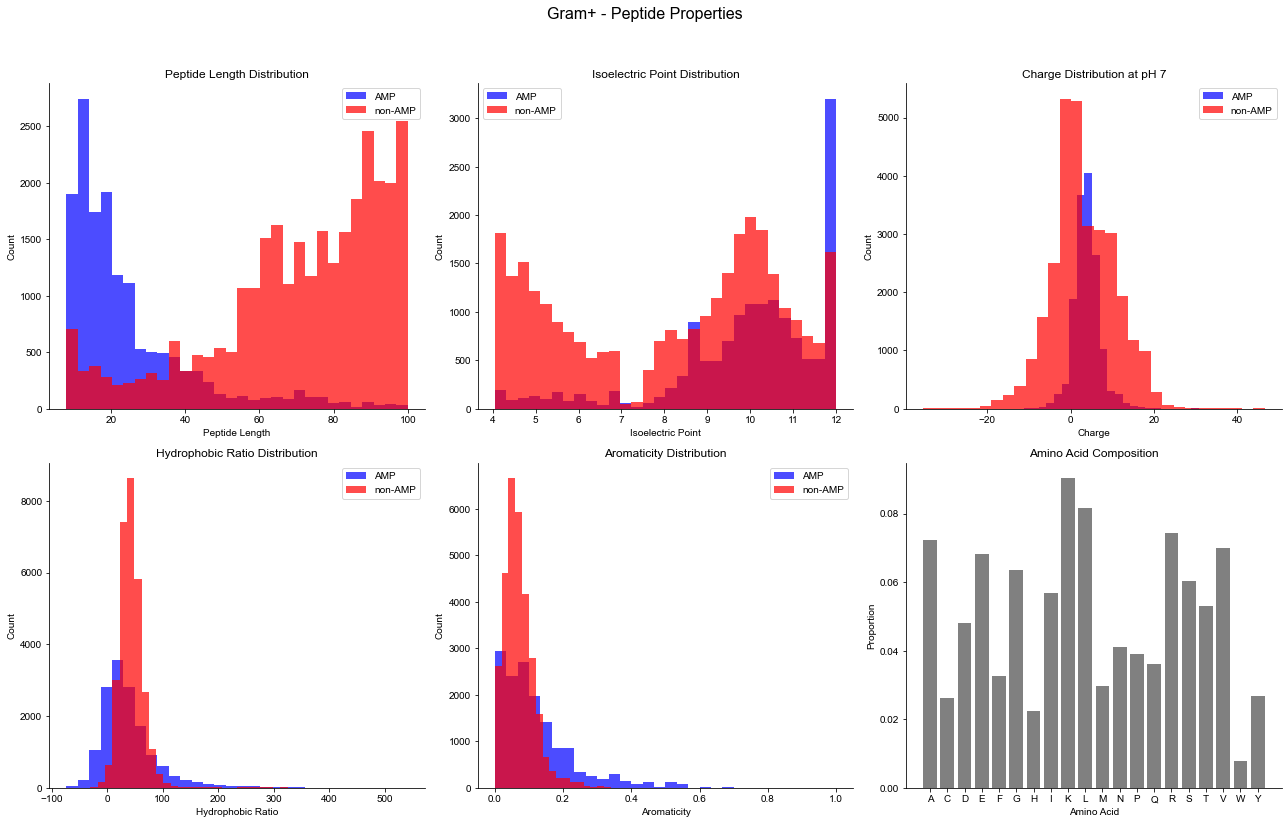

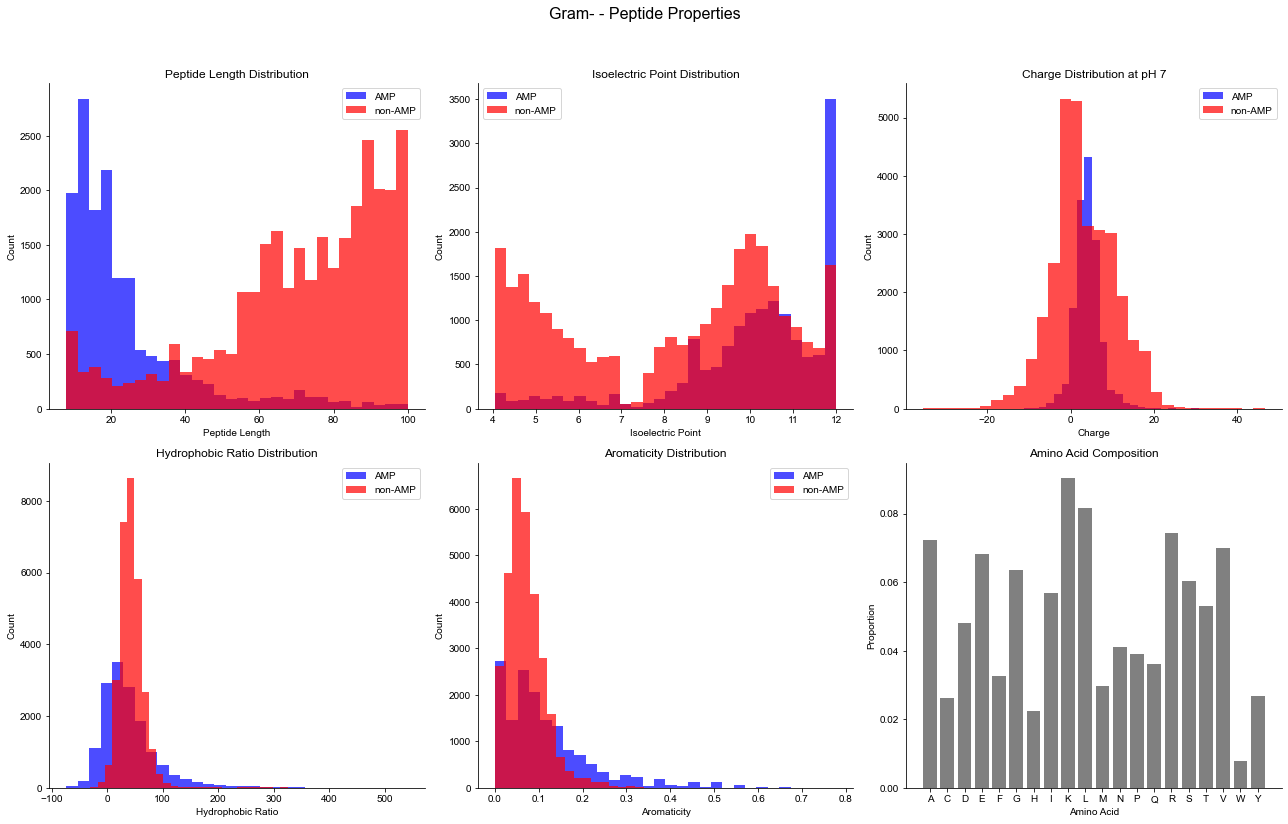

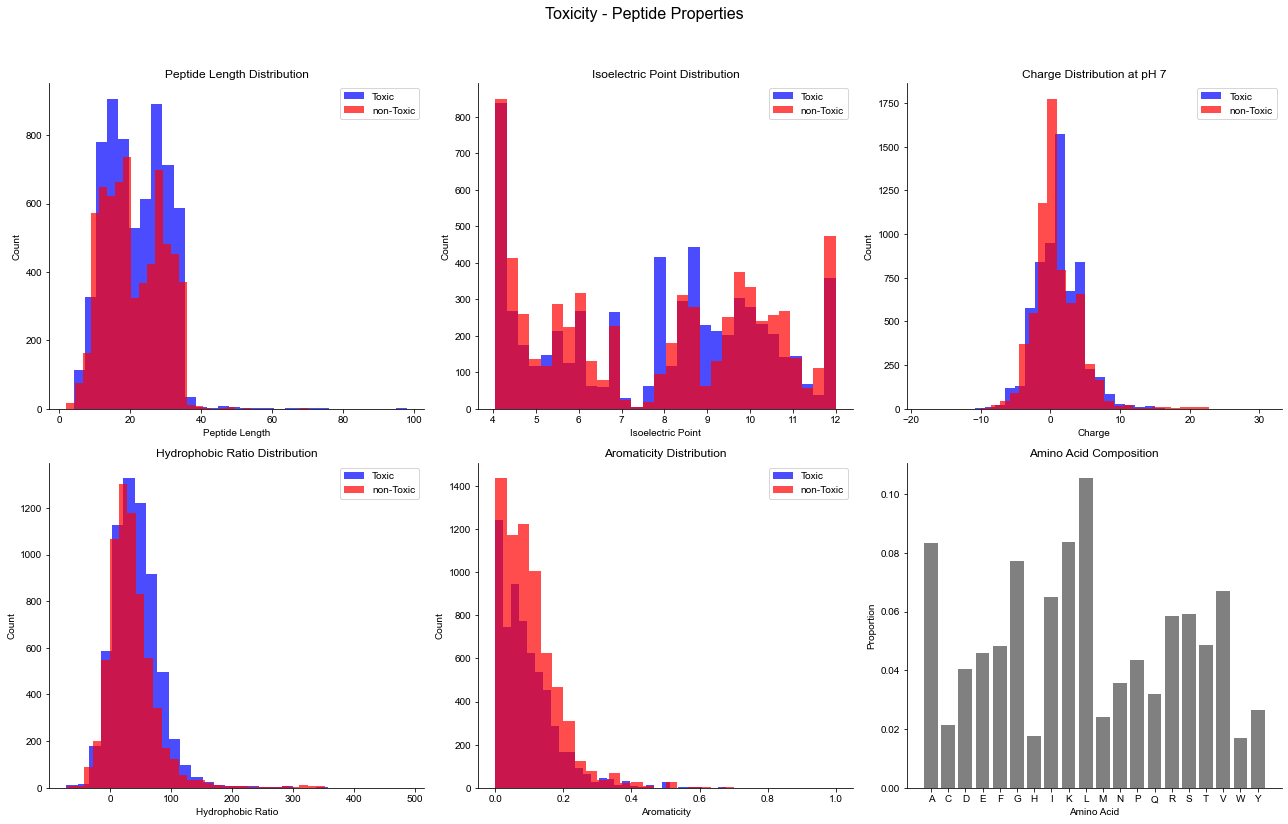

In [29]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
ds_paths = {'Global AMP': '../data/AMP_new/AMP_2024_09_13_.tsv', 'Gram+': '../data/AMP_new/AMP_2024_09_13_anti_Gram+.tsv',
            'Gram-': '../data/AMP_new/AMP_2024_09_13_anti_Gram-.tsv', 'Toxicity': '../data/tox/tox_merged_all.tsv'}

ds_dict = {}
for ds, path in ds_paths.items():
    df = pd.read_csv(path, header=None, sep='\t')
    ds_dict[ds] = df
    non_active = df[df[3] == 0]
    active = df[df[3] == 1]
    print(f'{ds}: Total {len(df)} sequences (1: {len(active)}, 0: {len(non_active)})')
    


# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

# Function to calculate peptide properties
def calculate_peptide_properties(peptides):
    properties = {
        'lengths': [],
        'isoelectric_points': [],
        'charges': [],
        'hydrophobic_ratios': [],
        'aromaticity': []
    }
    aa_composition = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    
    for peptide in peptides:
        analysis = ProteinAnalysis(peptide)
        properties['lengths'].append(len(peptide))
        properties['isoelectric_points'].append(analysis.isoelectric_point())
        properties['charges'].append(analysis.charge_at_pH(7.0))
        properties['hydrophobic_ratios'].append(analysis.instability_index())
        properties['aromaticity'].append(analysis.aromaticity())

        comp = analysis.count_amino_acids()
        for aa, count in comp.items():
            aa_composition[aa] += count

    total_aa = sum(aa_composition.values())
    for aa in aa_composition:
        aa_composition[aa] /= total_aa

    return properties, aa_composition

# Calculate and visualize properties for each dataset
for ds, df in ds_dict.items():
    lab_1 = 'Toxic' if ds == 'Toxicity' else 'AMP'
    lab_2 = 'non-Toxic' if ds == 'Toxicity' else 'non-AMP'
    peptides_active = df[df[3] == 1][2].tolist()
    peptides_non_active = df[df[3] == 0][2].tolist()

    properties_active, _ = calculate_peptide_properties(peptides_active)
    properties_non_active, aa_composition = calculate_peptide_properties(peptides_non_active)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{ds} - Peptide Properties', fontsize=16)

    # Plot length distribution
    axes[0, 0].hist(properties_active['lengths'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[0, 0].hist(properties_non_active['lengths'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[0, 0].set_title('Peptide Length Distribution')
    axes[0, 0].set_xlabel('Peptide Length')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()
    axes[0, 0].spines[['top', 'right']].set_visible(False)

    # Plot isoelectric point distribution
    axes[0, 1].hist(properties_active['isoelectric_points'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[0, 1].hist(properties_non_active['isoelectric_points'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[0, 1].set_title('Isoelectric Point Distribution')
    axes[0, 1].set_xlabel('Isoelectric Point')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    axes[0, 1].spines[['top', 'right']].set_visible(False)

    # Plot charge distribution
    axes[0, 2].hist(properties_active['charges'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[0, 2].hist(properties_non_active['charges'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[0, 2].set_title('Charge Distribution at pH 7')
    axes[0, 2].set_xlabel('Charge')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].legend()
    axes[0, 2].spines[['top', 'right']].set_visible(False)

    # Plot hydrophobic ratio distribution
    axes[1, 0].hist(properties_active['hydrophobic_ratios'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[1, 0].hist(properties_non_active['hydrophobic_ratios'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[1, 0].set_title('Hydrophobic Ratio Distribution')
    axes[1, 0].set_xlabel('Hydrophobic Ratio')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()
    axes[1, 0].spines[['top', 'right']].set_visible(False)

    # Plot aromaticity distribution
    axes[1, 1].hist(properties_active['aromaticity'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[1, 1].hist(properties_non_active['aromaticity'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[1, 1].set_title('Aromaticity Distribution')
    axes[1, 1].set_xlabel('Aromaticity')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].spines[['top', 'right']].set_visible(False)

    # Plot amino acid composition
    axes[1, 2].bar(list(aa_composition.keys()), list(aa_composition.values()), color='gray')
    axes[1, 2].set_title('Amino Acid Composition')
    axes[1, 2].set_xlabel('Amino Acid')
    axes[1, 2].set_ylabel('Proportion')
    axes[1, 2].spines[['top', 'right']].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'peptide_properties_{ds}.pdf', dpi=200, bbox_inches='tight')
    plt.show()
    break


Global AMP: Total 55209 sequences (1: 25004, 0: 30205)
Gram+: Total 45069 sequences (1: 14864, 0: 30205)
Gram-: Total 45493 sequences (1: 15288, 0: 30205)
Toxicity: Total 12961 sequences (1: 6318, 0: 6643)


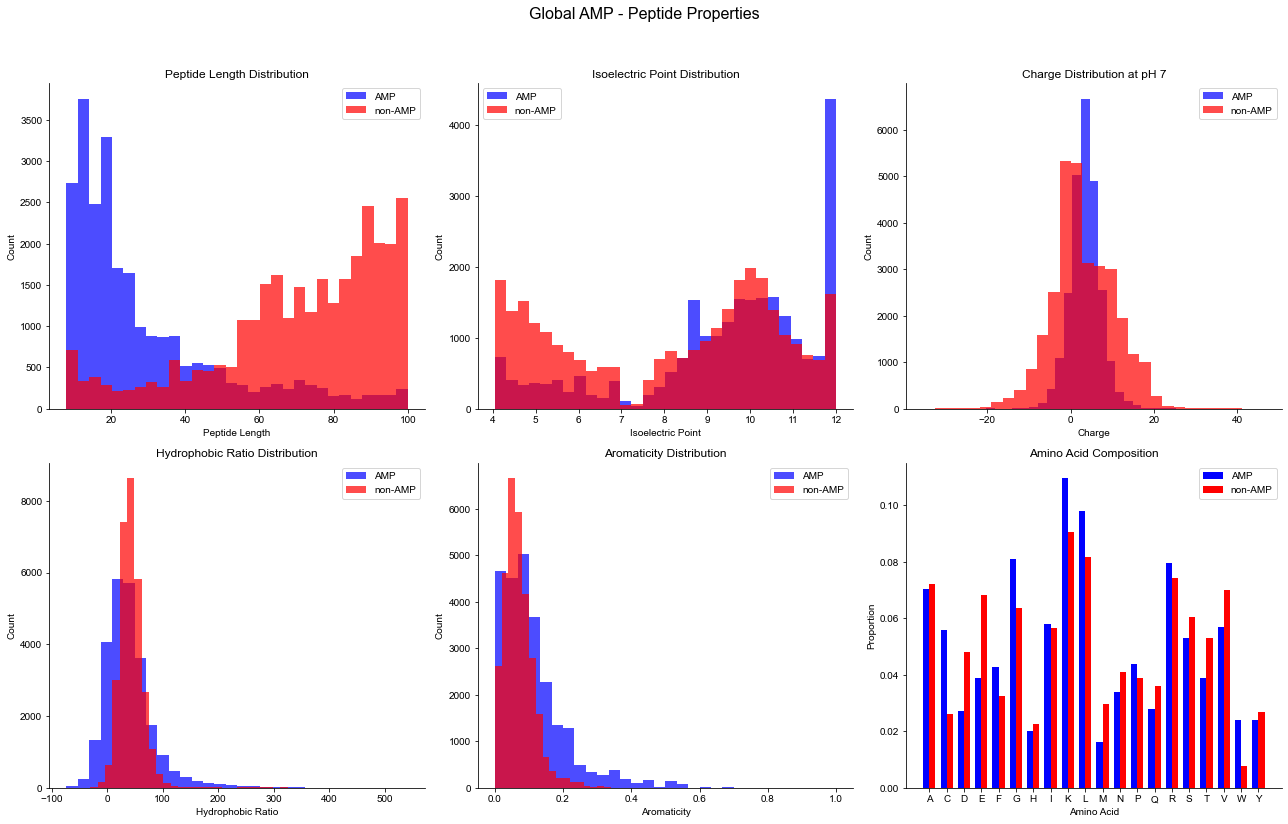

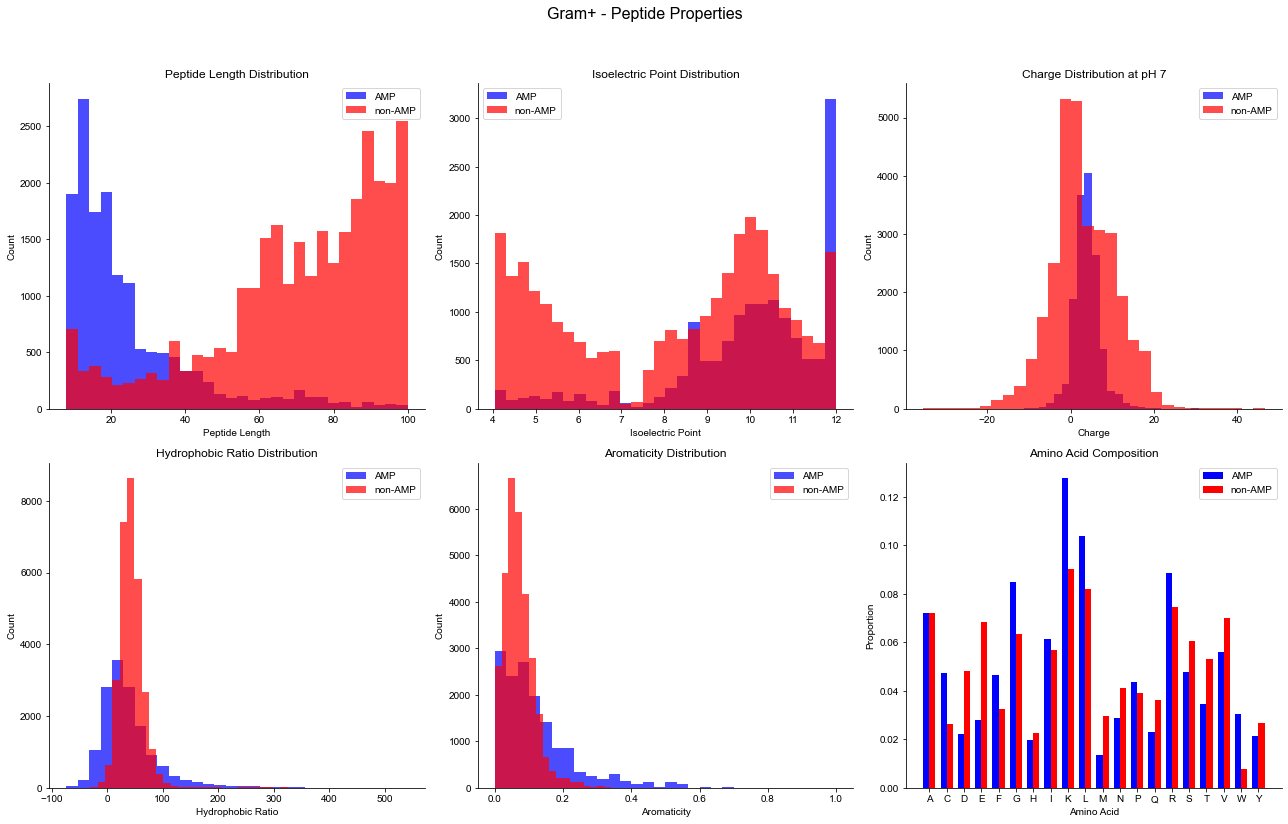

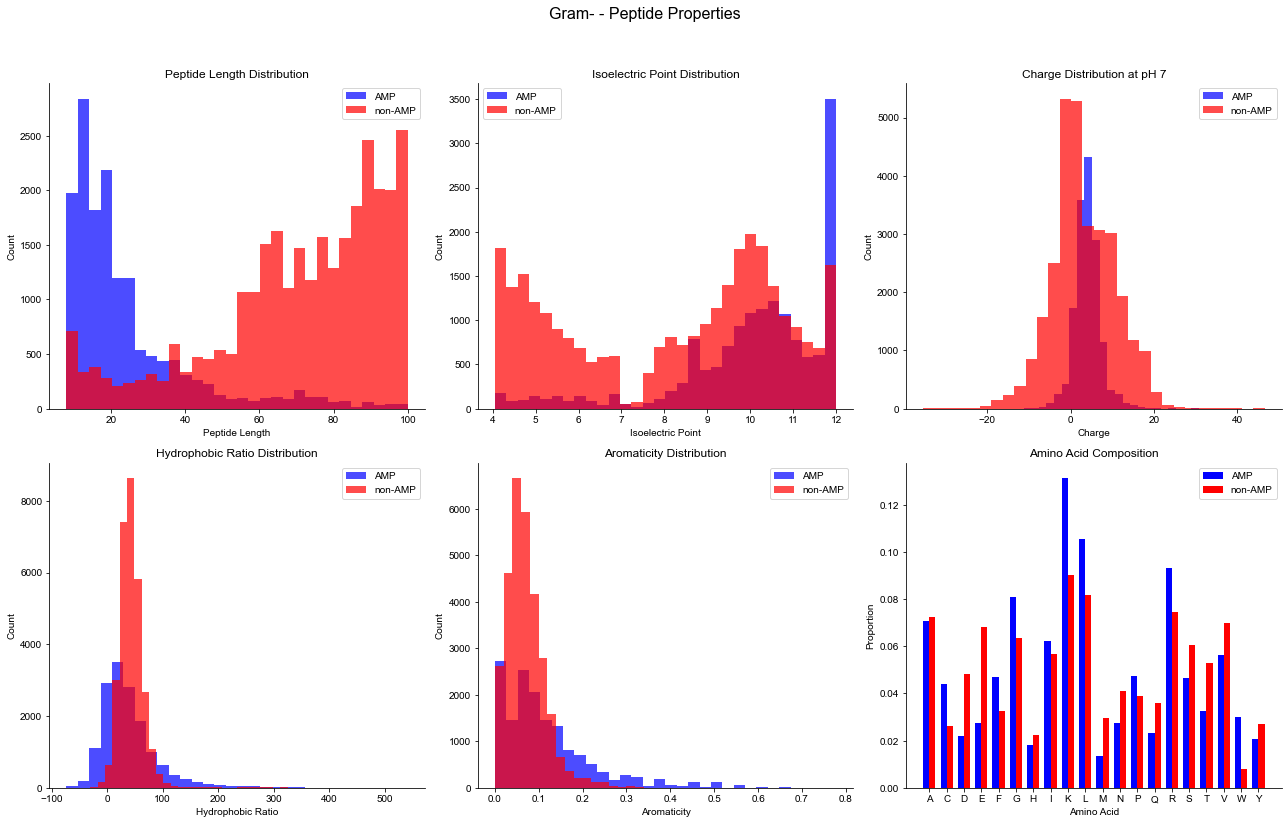

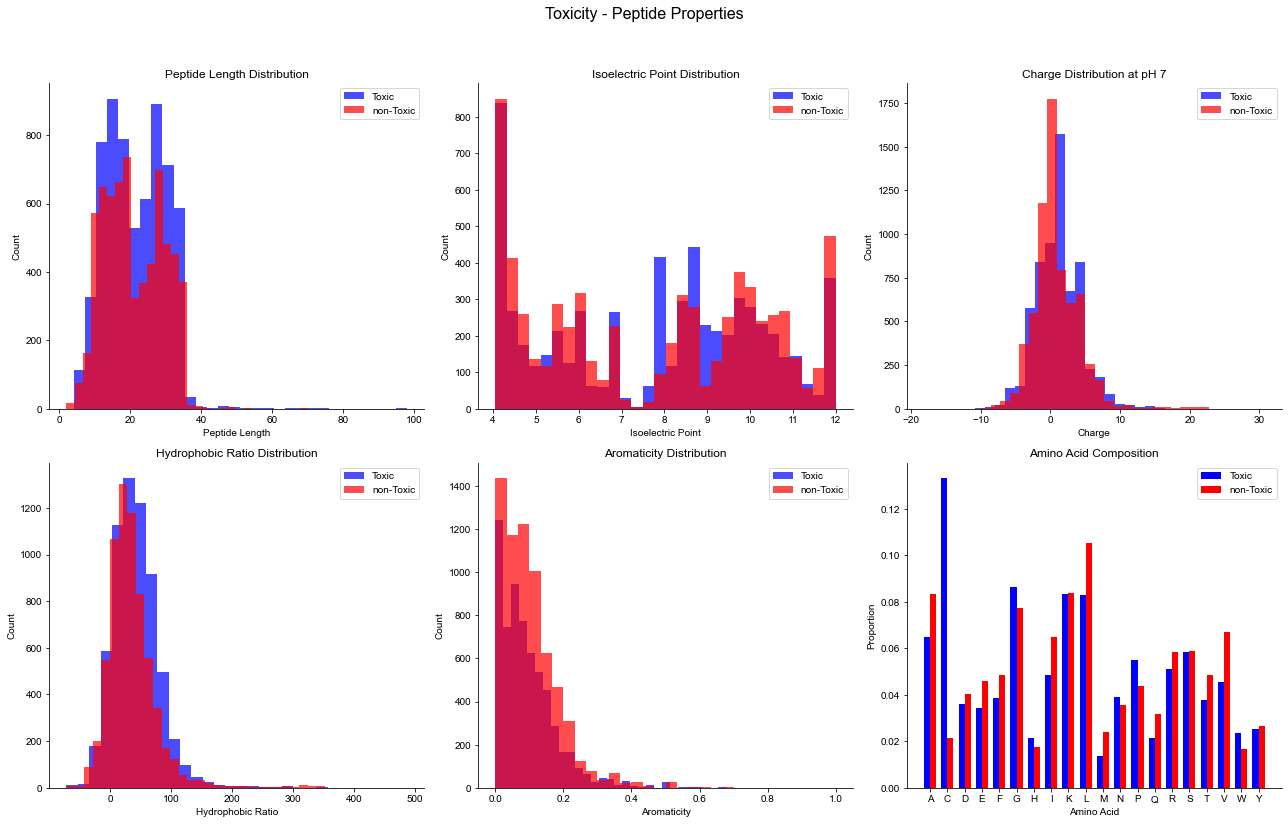

In [49]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

ds_paths = {'Global AMP': '../data/AMP_new/AMP_2024_09_13_.tsv', 
            'Gram+': '../data/AMP_new/AMP_2024_09_13_anti_Gram+.tsv',
            'Gram-': '../data/AMP_new/AMP_2024_09_13_anti_Gram-.tsv', 
            'Toxicity': '../data/tox/tox_merged_all.tsv'}

ds_dict = {}
for ds, path in ds_paths.items():
    df = pd.read_csv(path, header=None, sep='\t')
    ds_dict[ds] = df
    non_active = df[df[3] == 0]
    active = df[df[3] == 1]
    print(f'{ds}: Total {len(df)} sequences (1: {len(active)}, 0: {len(non_active)})')


# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

# Function to calculate peptide properties
def calculate_peptide_properties(peptides):
    properties = {
        'lengths': [],
        'isoelectric_points': [],
        'charges': [],
        'hydrophobic_ratios': [],
        'aromaticity': []
    }
    aa_composition = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    
    for peptide in peptides:
        analysis = ProteinAnalysis(peptide)
        properties['lengths'].append(len(peptide))
        properties['isoelectric_points'].append(analysis.isoelectric_point())
        properties['charges'].append(analysis.charge_at_pH(7.0))
        properties['hydrophobic_ratios'].append(analysis.instability_index())
        properties['aromaticity'].append(analysis.aromaticity())

        comp = analysis.count_amino_acids()
        for aa, count in comp.items():
            aa_composition[aa] += count

    total_aa = sum(aa_composition.values())
    for aa in aa_composition:
        aa_composition[aa] /= total_aa

    return properties, aa_composition

# Calculate and visualize properties for each dataset
for ds, df in ds_dict.items():
    lab_1 = 'Toxic' if ds == 'Toxicity' else 'AMP'
    lab_2 = 'non-Toxic' if ds == 'Toxicity' else 'non-AMP'
    peptides_active = df[df[3] == 1][2].tolist()
    peptides_non_active = df[df[3] == 0][2].tolist()

    properties_active, _ = calculate_peptide_properties(peptides_active)
    properties_non_active, aa_composition = calculate_peptide_properties(peptides_non_active)

    # Calculate amino acid composition separately for active and non-active peptides
    properties_active, aa_composition_active = calculate_peptide_properties(peptides_active)
    properties_non_active, aa_composition_non_active = calculate_peptide_properties(peptides_non_active)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{ds} - Peptide Properties', fontsize=16)

    # Plot length distribution
    axes[0, 0].hist(properties_active['lengths'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[0, 0].hist(properties_non_active['lengths'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[0, 0].set_title('Peptide Length Distribution')
    axes[0, 0].set_xlabel('Peptide Length')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()
    axes[0, 0].spines[['top', 'right']].set_visible(False)

    # Plot isoelectric point distribution
    axes[0, 1].hist(properties_active['isoelectric_points'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[0, 1].hist(properties_non_active['isoelectric_points'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[0, 1].set_title('Isoelectric Point Distribution')
    axes[0, 1].set_xlabel('Isoelectric Point')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    axes[0, 1].spines[['top', 'right']].set_visible(False)

    # Plot charge distribution
    axes[0, 2].hist(properties_active['charges'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[0, 2].hist(properties_non_active['charges'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[0, 2].set_title('Charge Distribution at pH 7')
    axes[0, 2].set_xlabel('Charge')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].legend()
    axes[0, 2].spines[['top', 'right']].set_visible(False)

    # Plot hydrophobic ratio distribution
    axes[1, 0].hist(properties_active['hydrophobic_ratios'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[1, 0].hist(properties_non_active['hydrophobic_ratios'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[1, 0].set_title('Hydrophobic Ratio Distribution')
    axes[1, 0].set_xlabel('Hydrophobic Ratio')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()
    axes[1, 0].spines[['top', 'right']].set_visible(False)

    # Plot aromaticity distribution
    axes[1, 1].hist(properties_active['aromaticity'], bins=30, color='blue', alpha=0.7, label=lab_1)
    axes[1, 1].hist(properties_non_active['aromaticity'], bins=30, color='red', alpha=0.7, label=lab_2)
    axes[1, 1].set_title('Aromaticity Distribution')
    axes[1, 1].set_xlabel('Aromaticity')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].spines[['top', 'right']].set_visible(False)

    # Plot amino acid composition side by side for AMP and non-AMP
    width = 0.35  # Bar width
    x = range(len(aa_composition_active))  # Positions of the bars
    axes[1, 2].bar([i - width/2 for i in x], list(aa_composition_active.values()), width=width, color='blue', label=lab_1)
    axes[1, 2].bar([i + width/2 for i in x], list(aa_composition_non_active.values()), width=width, color='red', label=lab_2)
    axes[1, 2].set_title('Amino Acid Composition')
    axes[1, 2].set_xlabel('Amino Acid')
    axes[1, 2].set_ylabel('Proportion')
    axes[1, 2].set_xticks(x)  # Set x-axis ticks to amino acid codes
    axes[1, 2].set_xticklabels(list(aa_composition_active.keys()))  # Set x-axis labels to amino acid codes
    axes[1, 2].legend()
    axes[1, 2].spines[['top', 'right']].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    ds_out = ds.replace(' ', '_')
    plt.savefig(f'peptide_properties_{ds_out}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
ds_dict['Global AMP']

,0,1,2,3
0,sp|A0A0U1RRE5|NBDY_HUMAN,68,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,0
1,sp|A0A1Z0YU59|MAMB1_DENAN,57,RPSFCNLPVKPGPCNGFFSAFYYSQKTNKCHSFTYGGCKGNANRFS...,0
2,sp|A0A384E129|O16A_CONMB,76,MKLTCVVIVAVLFLTACQLITADDSRSTQRHRALRSTTKLSMSTRC...,0
3,sp|A0A6P3CW73|CYCTI_TITOB,58,MKFIIVLLLLTALTLTSIPVIEGILKRCKTYDDCKDVCKARKGKCE...,0
4,sp|A0QZ48|PUP_MYCS2,64,MAQEQTKRGGGGGEDDDLPGASAAGQERREKLTEETDDLLDEIDDV...,0
...,...,...,...,...
55204,LAMP2_L13A021812,50,YRQSMNNFQGLRSFGCRFGTCTVQKLAHQIYQFTDKDKDNVAPRSK...,1
55205,LAMP2_L13A024571,50,YSGKDCLKDMGGYALAGAGSGALWGAPAGGVGALPGAFVGAHVGAI...,1
55206,LAMP2_L13A025678,50,YSSKDCLKDIGKGIGAGTVAGAAGGGLAAGLGAIPGAFVGAHFGVI...,1
55207,LAMP2_L13A012071,50,YSYKKIDCGGACAARCRLSSRPRLCNRACGTCCARCNCVPPGTSGN...,1
